In [1]:
# !pip install imgaug

In [1]:
import os
import random
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import numpy as np

In [2]:
image_folder = './data/original image'
annotation_folder = './data/annotation'
output_folder = './dataset'
aug_folder = './aug data'

In [3]:
# Get the list of image files
image_files = os.listdir(image_folder)

y_label = []

# Process each image
for image_file in tqdm(image_files):
    # Load the corresponding annotation
    annotation_path = os.path.join(annotation_folder, image_file.replace(".jpg", ".txt"))
    with open(annotation_path, "r") as f:
        annotation_data = list(map(float, f.read().split()))

    # Process the annotation data
    label = int(annotation_data[0])
    bbox = annotation_data[1:]

    y_label.append(label)

# Convert lists to NumPy arrays
y_label = np.array(y_label)
print(len(np.unique(y_label)))

100%|█████████████████████████████████████| 3019/3019 [00:00<00:00, 8838.92it/s]

10


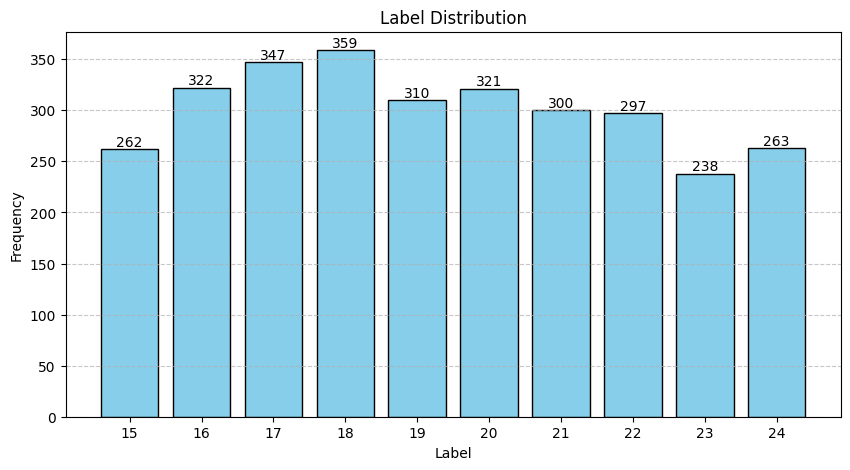

In [6]:
# Visualize label distribution
plt.figure(figsize=(10, 5))
plt.hist(y_label, bins=np.arange(y_label.min(), y_label.max() + 2) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(np.arange(y_label.min(), y_label.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adding text annotations
for i in range(len(np.unique(y_label))):
    count = np.sum(y_label == i+15)
    plt.text(i+15, count, str(count), ha='center', va='bottom')

plt.show()

In [6]:
# Create output folders
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [7]:
# Set the percentage for train, validation, and test
train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1


In [8]:
# Get list of image files
image_files = os.listdir(image_folder)
print(len(image_files))

3019


In [9]:
# Randomly shuffle the file list
random.shuffle(image_files)

In [10]:
# Calculate split indices
train_split = int(train_percentage * len(image_files))
val_split = train_split + int(val_percentage * len(image_files))

# Split the data
train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

In [11]:
# Function to move files to corresponding folders
def move_files(files, source_folder, annotation_folder, destination_folder):
    for filename in files:
        image_path = os.path.join(image_folder, filename)
        annotation_path = os.path.join(annotation_folder, filename.replace('.jpg', '.txt'))

        destination_image_path = os.path.join(destination_folder, filename)
        destination_annotation_path = os.path.join(destination_folder, filename.replace('.jpg', '.txt'))

        shutil.copy(image_path, destination_image_path)
        shutil.copy(annotation_path, destination_annotation_path)

In [12]:
# Move files to corresponding folders
move_files(train_files, image_folder, annotation_folder, train_folder)
move_files(val_files, image_folder, annotation_folder, val_folder)
move_files(test_files, image_folder, annotation_folder, test_folder)

In [13]:
# Define the combined augmentation sequence
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-5, 5)),
    iaa.Affine(scale=(0.95, 1.05)),
    iaa.Affine(translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)}),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.ContrastNormalization((0.5, 1.5)),
])

/mnt/6C44792F4478FD60/Software ENG/Projects/human-activity-detection/venv/lib/python3.10/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [14]:
num_augmentations = 5

In [15]:
# Create folders for augmented train, val, and test
augmented_train_folder = os.path.join(aug_folder, 'train')
augmented_val_folder = os.path.join(aug_folder, 'val')
augmented_test_folder = os.path.join(aug_folder, 'test')

os.makedirs(augmented_train_folder, exist_ok=True)
os.makedirs(augmented_val_folder, exist_ok=True)
os.makedirs(augmented_test_folder, exist_ok=True)

In [16]:
# Function to move files to corresponding folder and apply augmentation
def move_and_augment_files(source_folder, destination_folder):
    files = os.listdir(source_folder)
    files = [file for file in files if file.lower().endswith('.jpg')]

    for filename in tqdm(files):
        image_path = os.path.join(source_folder, filename)
        annotation_path = os.path.join(source_folder, filename.replace('.jpg', '.txt'))

        for i in range(num_augmentations):
            destination_image_path = os.path.join(destination_folder, f"{filename.replace('.jpg', '')}_aug_{i}.jpg")
            destination_annotation_path = os.path.join(destination_folder, f"{filename.replace('.jpg', '')}_aug_{i}.txt")

            # Read the image
            image = cv2.imread(image_path)
            
            # Read the annotation
            with open(annotation_path, 'r') as annotation_file:
                annotation = annotation_file.readline().strip().split()
                label = int(annotation[0])
                center_x, center_y, width, height = map(float, annotation[1:])

                absolute_x = center_x * image.shape[1]
                absolute_y = center_y * image.shape[0]
                absolute_width = width * image.shape[1]
                absolute_height = height * image.shape[0]

                # Create BoundingBoxesOnImage object
                bounding_boxes = BoundingBoxesOnImage([
                    BoundingBox(
                        x1=absolute_x - absolute_width / 2,
                        y1=absolute_y - absolute_height / 2,
                        x2=absolute_x + absolute_width / 2,
                        y2=absolute_y + absolute_height / 2
                    )
                ], shape=image.shape)

            # Apply augmentation
            augmented_image, augmented_bounding_boxes = augmentation(image=image, bounding_boxes=bounding_boxes)
            
            new_height, new_width, _ = augmented_image.shape
    
            augmented_annotations = np.array([
                [
                    (box.x1 + box.x2) / (2 * new_width),
                    (box.y1 + box.y2) / (2 * new_height),
                    (box.x2 - box.x1) / new_width,
                    (box.y2 - box.y1) / new_height
                ]
                for box in augmented_bounding_boxes.bounding_boxes
            ])

            destination_image_path = os.path.join(destination_folder, f"{filename.replace('.jpg', '')}_aug_0.jpg")
            cv2.imwrite(destination_image_path, augmented_image)

            augmented_annotation = np.concatenate([np.array([[label]]), augmented_annotations], axis=1)
            destination_annotation_path = os.path.join(destination_folder, f"{filename.replace('.jpg', '')}_aug_0.txt")
            with open(destination_annotation_path, 'w') as f:
                for annotation in augmented_annotation:
                    f.write(' '.join(map(str, annotation)) + '\n')
            

In [17]:
# Move and augment files for augmented training set
move_and_augment_files(train_folder, augmented_train_folder)

# Move and augment files for augmented validation set
move_and_augment_files(val_folder, augmented_val_folder)


100%|███████████████████| 603/603 [00:39<00:00, 15.13it/s]


In [18]:
for filename in test_folder:
    shutil.copytree(test_folder, augmented_test_folder, dirs_exist_ok=True)